In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1245, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [4]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

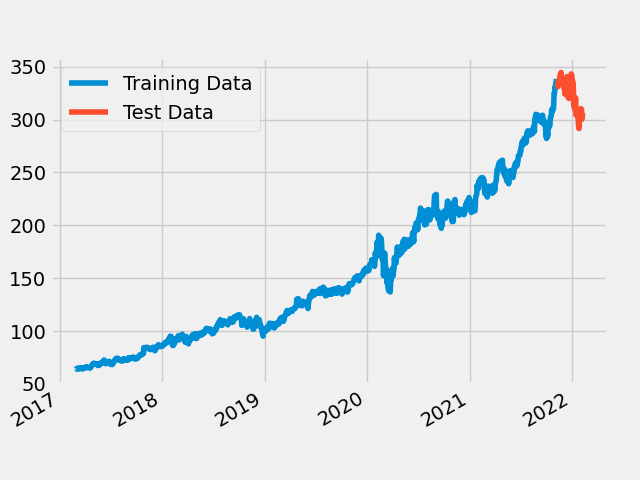

In [5]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [6]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [7]:
import wandb

run = wandb.init()
artifact = run.use_artifact('alpheron/stock-predictions-alltime/Time-Series:v2', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stock-prediction (use `wandb login --relogin` to force relogin)


In [8]:
from tensorflow import keras

model = keras.models.load_model(abspath('artifacts/Time-Series:v2'), compile=False)

2022-02-27 16:54:14.846704: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 16:54:14.847563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 16:54:14.847885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 560

systemMemory: 16.00 GB
maxCacheSize: 2.00 GB



In [9]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

In [10]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(63, 60, 1)


In [11]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

2022-02-27 16:54:21.989477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-27 16:54:22.229373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [12]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(63, 1)


,Open
Date,
2021-11-08,330.373016
2021-11-09,332.368591
2021-11-10,333.788208
2021-11-11,334.283783
2021-11-12,333.791718


<AxesSubplot:xlabel='Date'>

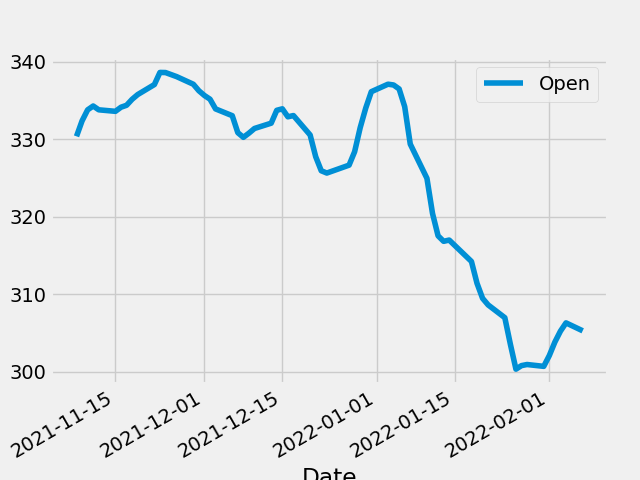

In [13]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

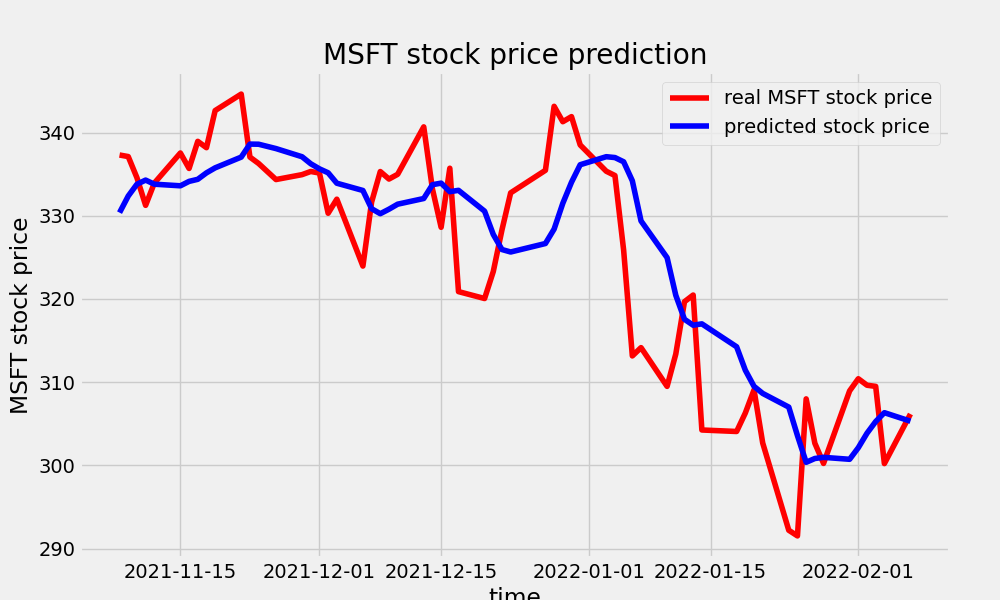

In [14]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [15]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is: {}".format(rmse))
    return rmse

RMSE = return_rmse(test_set, predicted)

the root mean squared error is: 7.356712791429518
